In [1]:
# Remember to update your path
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/rz14/Documents/QR_Qishi/QishiQR/')

from pathlib import Path

from Backtesting.Vectorized.cross_compare import *

from Utils.lm import gen_strategy, LM_model

import json
import warnings
warnings.filterwarnings(action='ignore')

# ====== Initial Configuration ========

try:
    with open('config.json','r') as f:
        config = json.load(f)
except:
    print("Failed to find the configuration file.")
        
DATA_DIR = config['Tick path']
OUTPUT_DIR = config['Output path']
Strategy_DIR = config['Strategy path']

model_order = config['Max model order']
number_of_states = config['State number']
freq = config['Frequency']
offset = config['Offset']
tca = None

# Ag
## Read in Ag strategy

In [2]:
ASSET = 'Ag'
ASSET_PATH = Path(config['Output path'], ASSET)
ASSET_PATH.mkdir(exist_ok=True, parents=True)

commodity = ASSET
exp_list = ['1601', '1602', '1603', '1604', '1605', '1606', '1607', '1608', '1609', '1610', '1611', '1612', '1701',
                '1702', '1703', '1704', '1705', '1706', '1707', '1708', '1709', '1710', '1711', '1712']



# === Main Routine ===
try:
    strategy = pd.read_csv(Strategy_DIR+'{}_5min_Stra.csv'.format(ASSET))
    slm = strategy[['prior', '0', '1', '2', 'total']].groupby(['prior']).sum().reset_index()
    slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)
except:
    strategy = gen_strategy(commodity, exp_list, number_of_states, model_order, data_root_dir=DATA_DIR, output=OUTPUT_DIR)
    strategy.to_csv('../../Strategy/{}_5min_Stra.csv'.format(ASSET),index=False)
    slm = strategy[['prior', '0', '1', '2', 'total']].groupby(['prior']).sum().reset_index()
    slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)

## Get 5 order models

In [3]:
def split_prior(x):
    default_prior = [0]*5
    for i, num in enumerate(list(x.strip('p'))):
        default_prior[i] = int(num)
    return np.array(default_prior).astype(np.int8)
    


In [4]:
Splited_slm = slm.copy()
Splited_slm['split prior'] = Splited_slm['prior'].apply(split_prior)
Splited_slm['Model Order'] = Splited_slm['prior'].apply(lambda x:len(x)-1)
data = Splited_slm[Splited_slm['Model Order']==5]
train_data = data['split prior'].values
train_label = data['signal'].values

train_data = np.vstack(train_data)
train_label = np.vstack(train_label)

In [5]:
data.shape

(243, 8)

## Train-valid split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.9)

## XGBoost Train

In [22]:
from xgboost import XGBClassifier 
model = XGBClassifier(base_score=1)


model.fit(X_train, y_train)

XGBClassifier(base_score=1, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

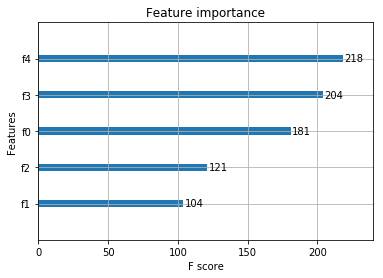

In [23]:
import xgboost
xgboost.plot_importance(model)

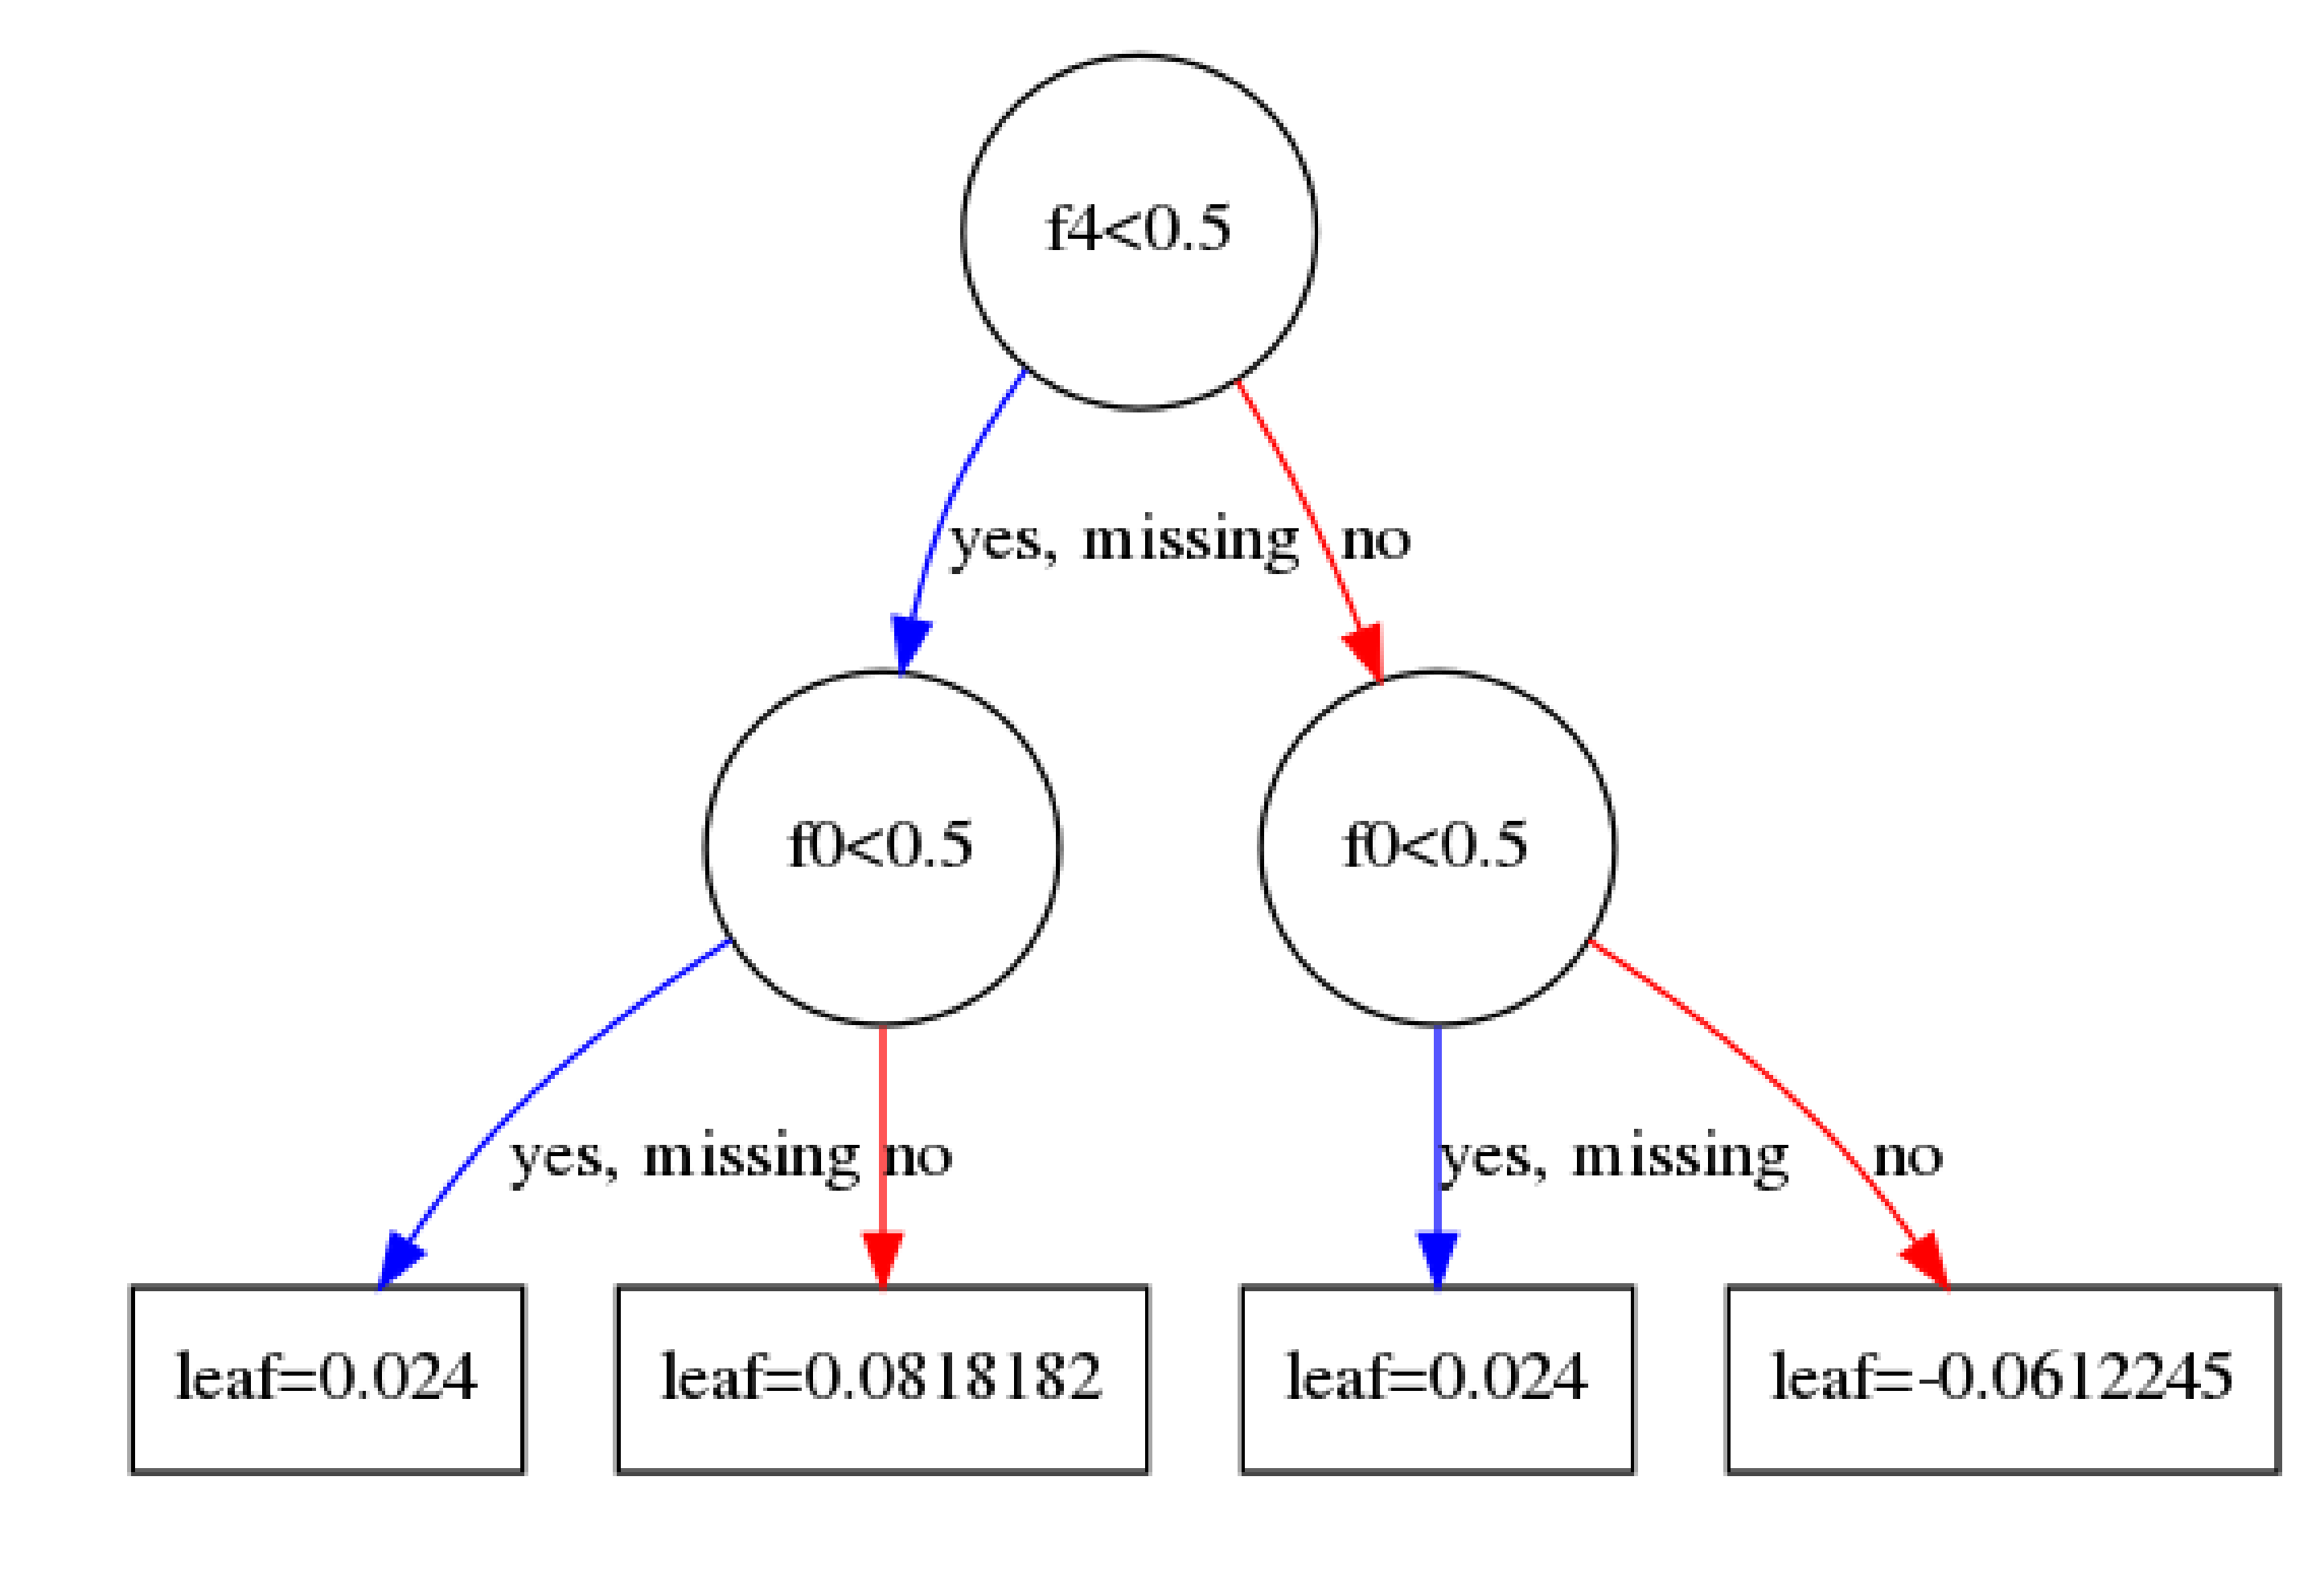

In [24]:
fig  = plt.figure(figsize=(12,8),dpi=300)
ax = plt.gca()
xgboost.plot_tree(model, ax=ax)

In [25]:
y_pred = model.predict(X_test)[:,np.newaxis]
Accurancy = (y_pred==y_test).sum()/len(y_test)
print(Accurancy)

0.7534246575342466


/home/rz14/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# rb

In [26]:
ASSET = 'rb'
ASSET_PATH = Path(config['Output path'], ASSET)
ASSET_PATH.mkdir(exist_ok=True, parents=True)

commodity = ASSET
exp_list = ['1601', '1602', '1603', '1604', '1605', '1606', '1607', '1608', '1609', '1610', '1611', '1612', '1701',
                '1702', '1703', '1704', '1705', '1706', '1707', '1708', '1709', '1710', '1711', '1712']



# === Main Routine ===
try:
    strategy = pd.read_csv(Strategy_DIR+'{}_5min_Stra.csv'.format(ASSET))
    slm = strategy[['prior', '0', '1', '2', 'total']].groupby(['prior']).sum().reset_index()
    slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)
except:
    strategy = gen_strategy(commodity, exp_list, number_of_states, model_order, data_root_dir=DATA_DIR, output=OUTPUT_DIR)
    strategy.to_csv('../../Strategy/{}_5min_Stra.csv'.format(ASSET),index=False)
    slm = strategy[['prior', '0', '1', '2', 'total']].groupby(['prior']).sum().reset_index()
    slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)

In [27]:
slm.tail()

,prior,0,1,2,total,signal
359,p22212,286,967,784,2037,1
360,p2222,628,1529,1358,3515,1
361,p22220,226,216,186,628,0
362,p22221,259,593,677,1529,2
363,p22222,213,626,519,1358,1


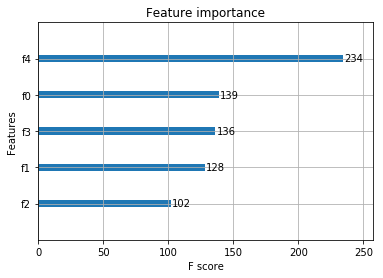

In [30]:
Splited_slm = slm.copy()
Splited_slm['split prior'] = Splited_slm['prior'].apply(split_prior)
Splited_slm['Model Order'] = Splited_slm['prior'].apply(lambda x:len(x)-1)
data = Splited_slm[Splited_slm['Model Order']==5]
train_data = data['split prior'].values
train_label = data['signal'].values

train_data = np.vstack(train_data)
train_label = np.vstack(train_label)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.9)

model = XGBClassifier(base_score=1)


model.fit(X_train, y_train)

xgboost.plot_importance(model)

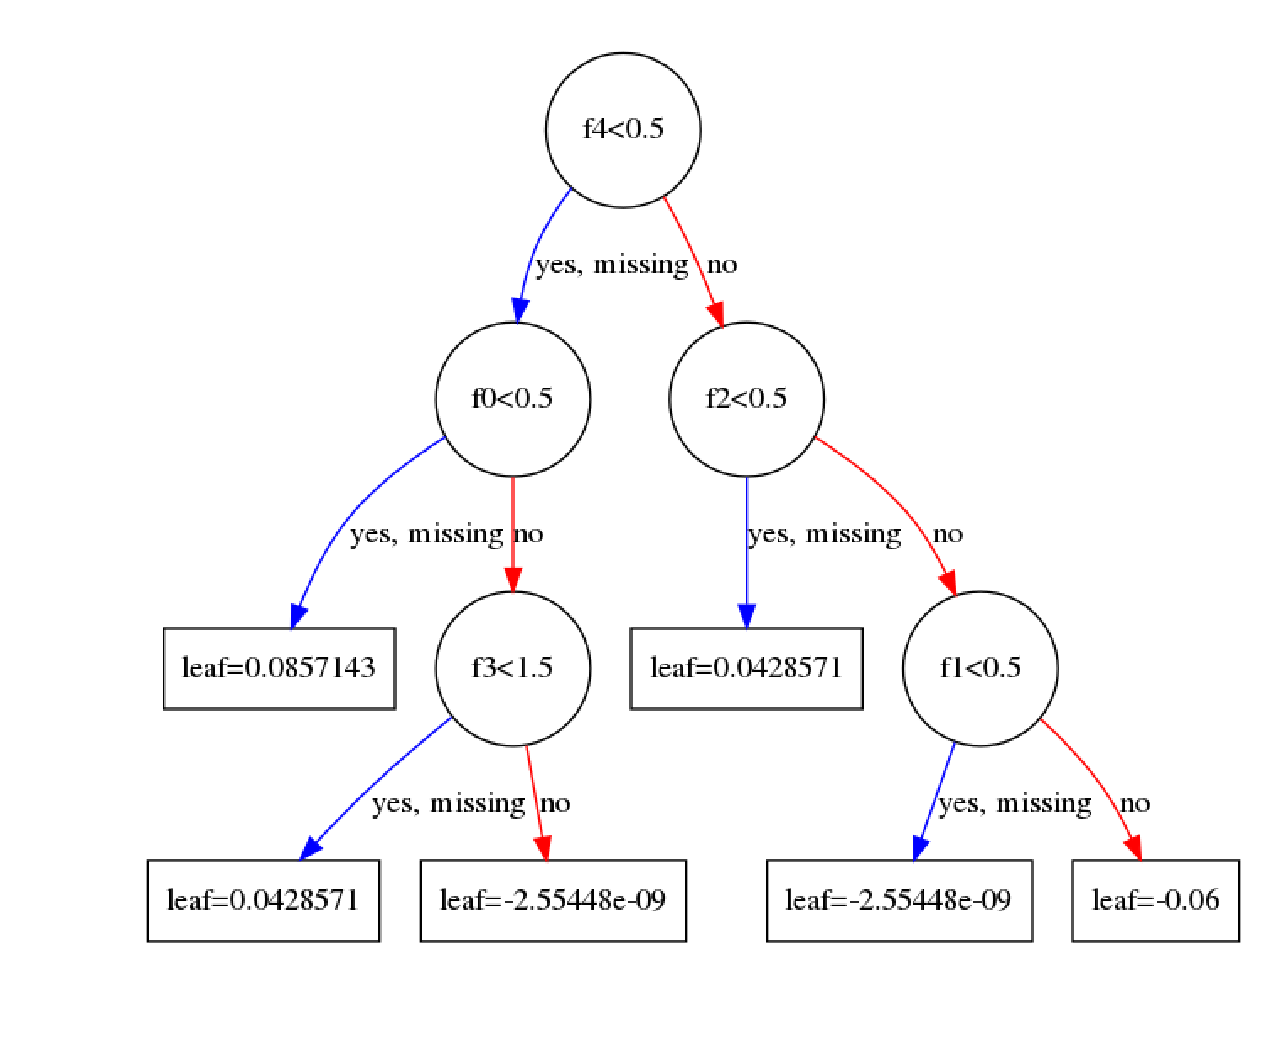

In [31]:
fig  = plt.figure(figsize=(8,4),dpi=300)
ax = plt.gca()
xgboost.plot_tree(model, ax=ax)

In [32]:
y_pred = model.predict(X_test)[:,np.newaxis]
Accurancy = (y_pred==y_test).sum()/len(y_test)
print(Accurancy)

0.7853881278538812


/home/rz14/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
